In [34]:
import os
import numpy as np
import pandas as pd
import h5py
import pickle as pkl
from pathlib import Path
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
name = 'vanilla_lstm_large_4k'

In [36]:
with open('../reports/{}/losses.pkl'.format(name), 'rb') as f:
    losses = pkl.load(f)

In [37]:
def get_losses(losses_dict):
    gen = [batch_loss for epoch_losses in losses_dict['generator'] for batch_loss in epoch_losses]
    disc = [batch_loss for epoch_losses in losses_dict['discriminator'] for batch_loss in epoch_losses]
    return np.array(gen), np.array(disc)

# Inspect losses

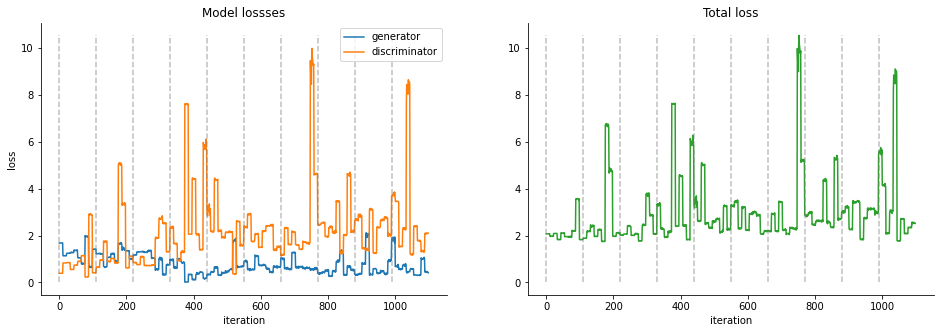

In [38]:
def plot_epochs(epochs, height, ax):
    for ep in epochs[::5]:
        ax.plot([ep, ep], [0, height], ls='--', c='0.5', alpha=0.5)

plt.figure(figsize=(16, 5))

gen_losses, disc_losses = get_losses(losses)
combined_loss = gen_losses + disc_losses
height = max(combined_loss)

epochs = np.linspace(0, len(gen_losses), 50, endpoint=False)

ax = plt.subplot(121)
ax.plot(gen_losses, label='generator')
ax.plot(disc_losses, label='discriminator')
plot_epochs(epochs, height, ax)

ax.set_title('Model lossses')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(combined_loss, c='C2')
plot_epochs(epochs, height, ax)

ax.set_title('Total loss')
ax.set_xlabel('iteration')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Visually inspect time series

In [39]:
epoch = None

samples_dir = Path('../samples/{}/'.format(name))

if epoch is None:
    samples_file = sorted([str(f) for f in samples_dir.glob('*.h5')])[-1]
else:
    samples_file = str(samples_dir / 'samples_epoch_{}.h5'.format(epoch))

with h5py.File(samples_file, 'r') as hf:
    x = np.array(hf.get('X'))

In [40]:
target_dir = '../reports/{}/figures/'.format(name)

if not os.path.isdir(target_dir):
    os.makedirs(target_dir)

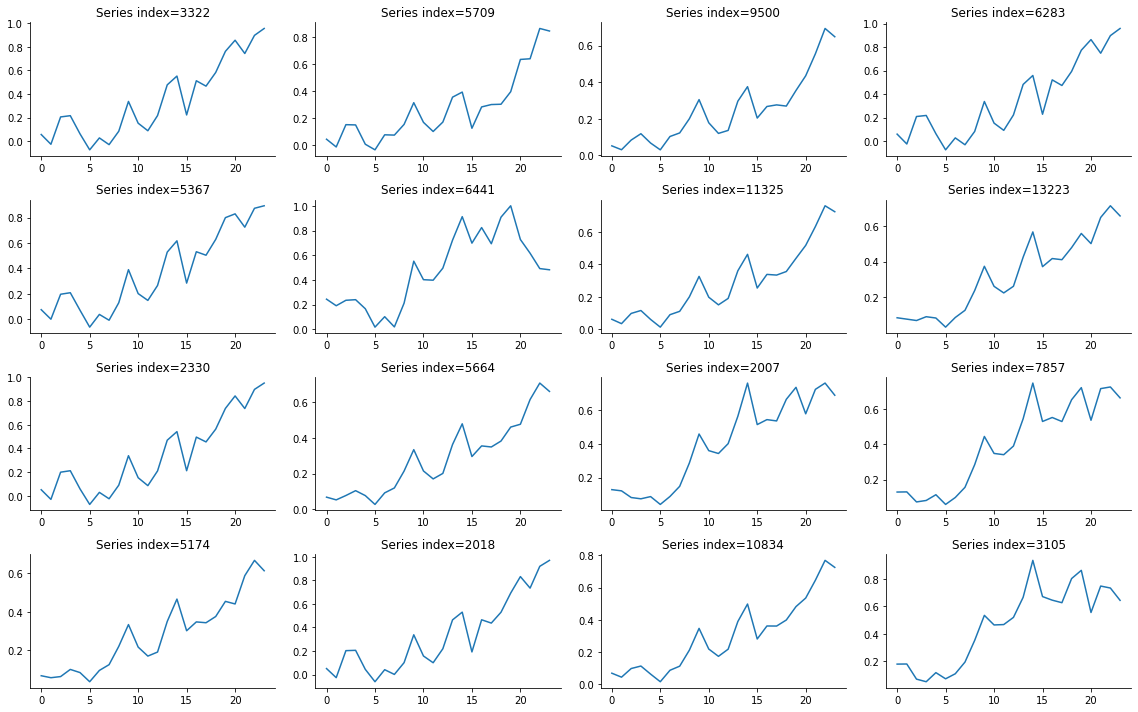

In [41]:
np.random.seed(1)
ind = np.random.permutation(len(x))[:16]

plt.figure(figsize=(16, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    series = x[ind[i]]
    ax.plot(series)
    ax.set_title('Series index={}'.format(ind[i]))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()

plt.savefig(target_dir + 'sample_series.png', bbox_inches='tight')

# Visualization

In [42]:
with open('../reports/{}/2d_projections.pkl'.format(name), 'rb') as f:
    projections = pkl.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../reports/vanilla_lstm_large_4k/2d_projections.pkl'

In [32]:
def simple_scatter(projections, proj_type):

    real_2d, fake_2d = projections

    r_x, r_y = real_2d.T
    f_x, f_y = fake_2d.T

    plt.figure(figsize=(8, 8))

    ax = plt.subplot(111)

    ax.scatter(r_x, r_y, alpha=0.5, label='real')
    ax.scatter(f_x, f_y, alpha=0.5, label='fake', c='C2')

    ax.axis('off')
    ax.legend()
    ax.set_title('{} projection'.format(proj_type))
    
    plt.savefig(target_dir + '{}_scatterplot.png'.format(proj_type), bbox_inches='tight')


def jointplot(projections, proj_type, xlabel='x', ylabel='y'):
    
    real_2d, fake_2d = projections

    r_x, r_y = real_2d.T
    f_x, f_y = fake_2d.T
    
    df = pd.DataFrame({xlabel: np.r_[r_x, f_x], ylabel: np.r_[r_y, f_y],
                       'type': ['real'] * len(r_x) + ['fake'] * len(f_x)})

    sns.jointplot(data=df, x=xlabel, y=ylabel, hue='type')

    plt.savefig(target_dir + '{}_jointplot.png'.format(proj_type), bbox_inches='tight')

    
    
def density(projections, proj_type, xlabel='x', ylabel='y'):
    
    real_2d, fake_2d = projections

    r_x, r_y = real_2d.T
    f_x, f_y = fake_2d.T
    

    plt.figure(figsize=(13, 6))

    mn_x = min(r_x.min(), f_x.min()) - 0.2
    mn_y = min(r_y.min(), f_y.min()) - 0.2
    mx_x = max(r_x.max(), f_x.max()) + 0.2
    mx_y = max(r_y.max(), f_y.max()) + 0.2

    ax = plt.subplot(121)

    xy = np.vstack([r_x, r_y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(r_x, r_y, c=z)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim([mn_x, mx_x])
    ax.set_ylim([mn_y, mx_y])

    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.set_title('Real timeseries')

    ax = plt.subplot(122)

    xy = np.vstack([f_x, f_y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(f_x, f_y, c=z)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('Fake timeseries')

    ax.set_xlim([mn_x, mx_x])
    ax.set_ylim([mn_y, mx_y])

    plt.tight_layout()
    
    plt.savefig(target_dir + '{}_densityplot.png'.format(proj_type), bbox_inches='tight')

## PCA

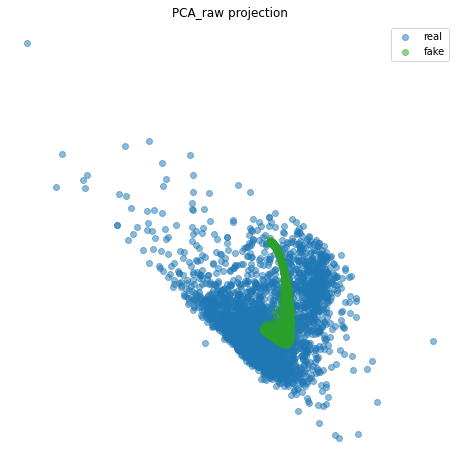

In [33]:
simple_scatter(projections['pca_raw'], 'PCA_raw')

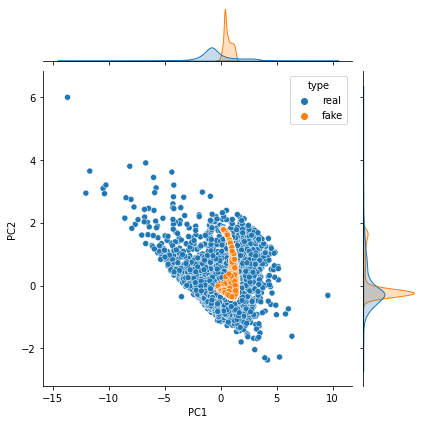

In [34]:
jointplot(projections['pca_raw'], proj_type='PCA_raw', xlabel='PC1', ylabel='PC2')

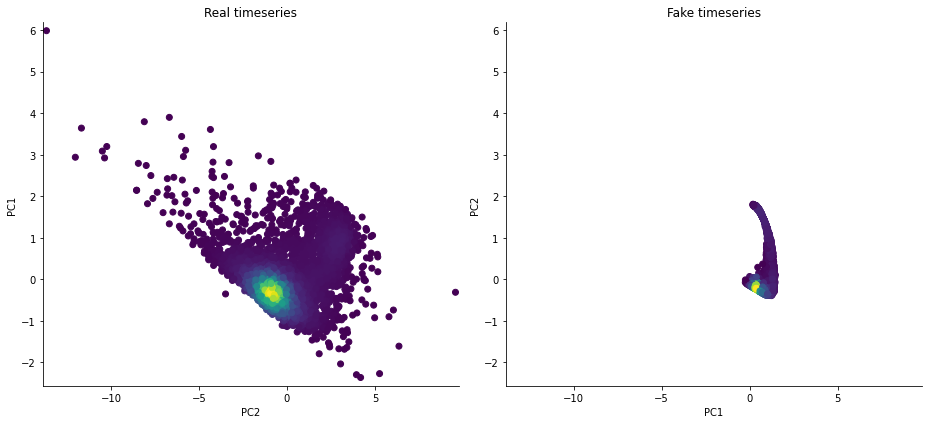

In [35]:
density(projections['pca_raw'], proj_type='PCA_raw', xlabel='PC1', ylabel='PC2')

## t-SNE

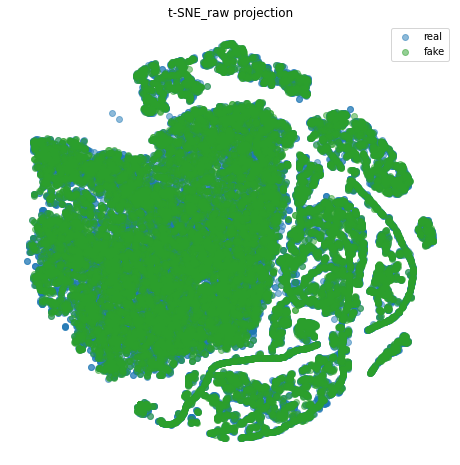

In [36]:
simple_scatter(projections['tsne_raw'], proj_type='t-SNE_raw')

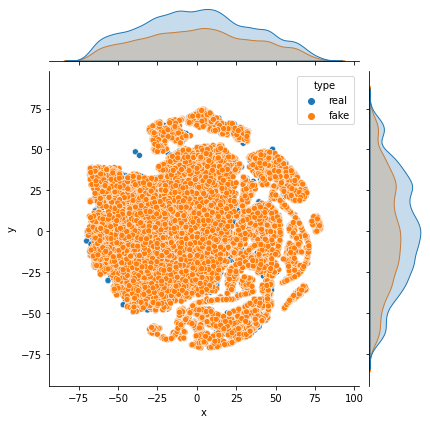

In [37]:
jointplot(projections['tsne_raw'], proj_type='t-SNE_raw')

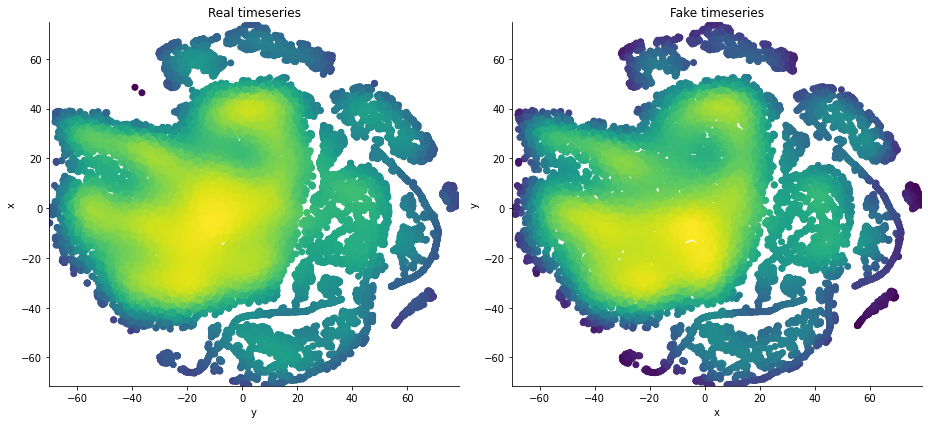

In [38]:
density(projections['tsne_raw'], proj_type='t-SNE_raw')

## Autoencoder

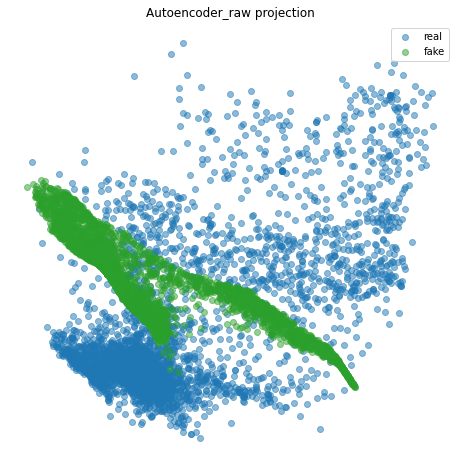

In [39]:
simple_scatter(projections['ae_raw'], proj_type='Autoencoder_raw')

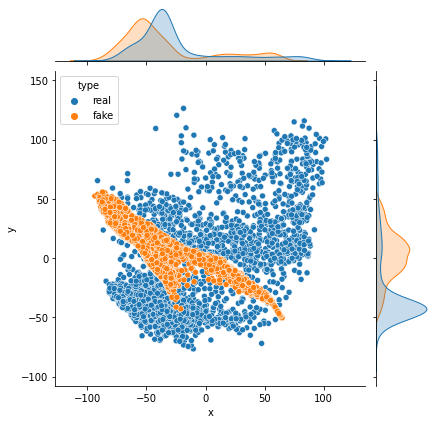

In [40]:
jointplot(projections['ae_raw'], proj_type='Autoencoder_raw')

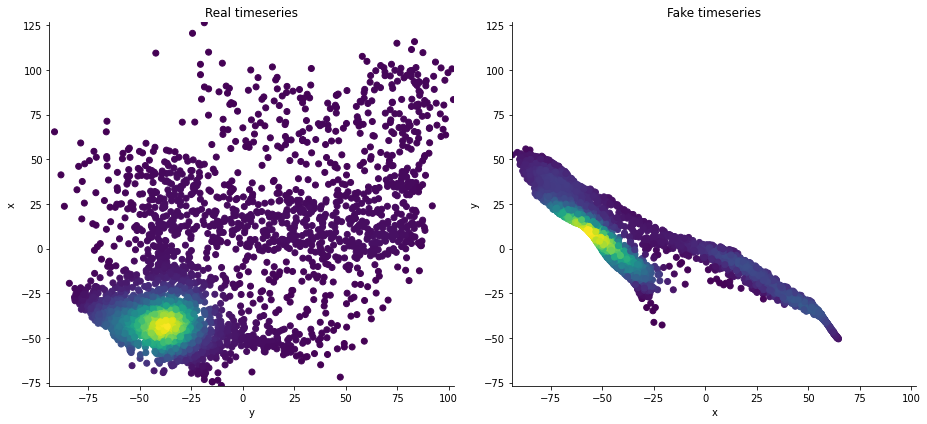

In [41]:
density(projections['ae_raw'], proj_type='Autoencoder_raw')

## Projections from extracted features

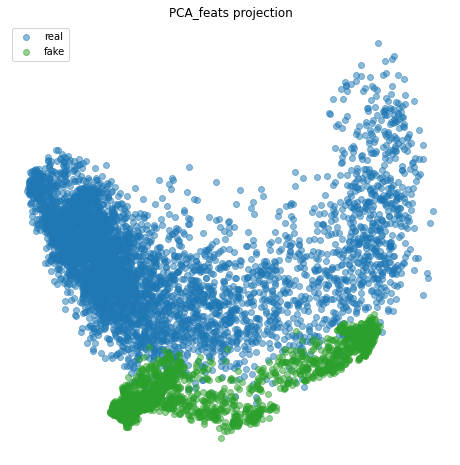

In [42]:
simple_scatter(projections['pca_feats'], 'PCA_feats')

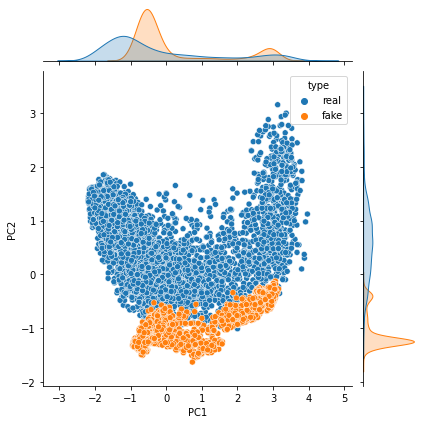

In [43]:
jointplot(projections['pca_feats'], proj_type='PCA_feats', xlabel='PC1', ylabel='PC2')

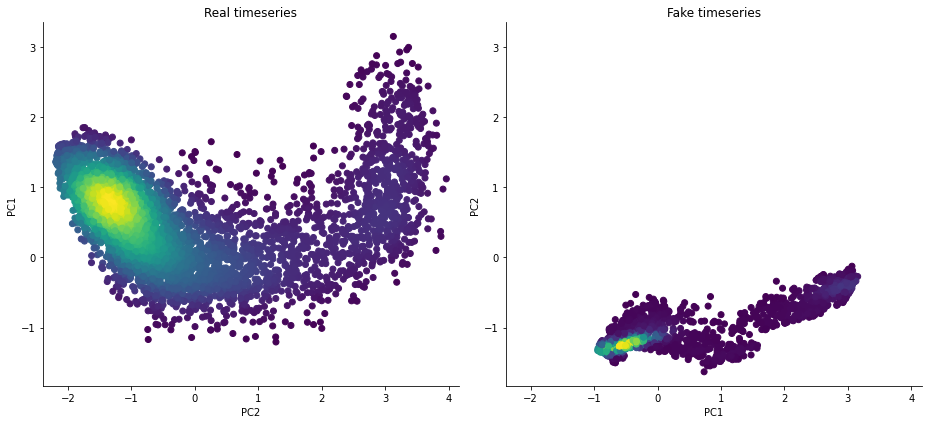

In [44]:
density(projections['pca_feats'], proj_type='PCA_feats', xlabel='PC1', ylabel='PC2')

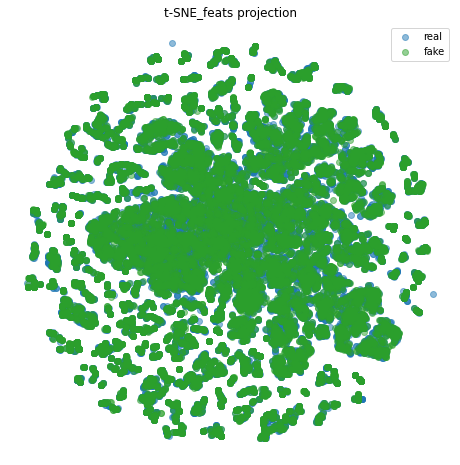

In [45]:
simple_scatter(projections['tsne_feats'], proj_type='t-SNE_feats')

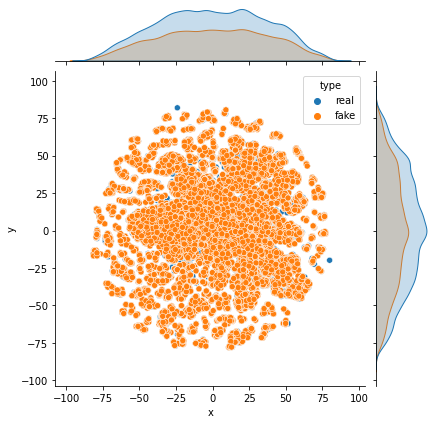

In [46]:
jointplot(projections['tsne_feats'], proj_type='t-SNE_feats')

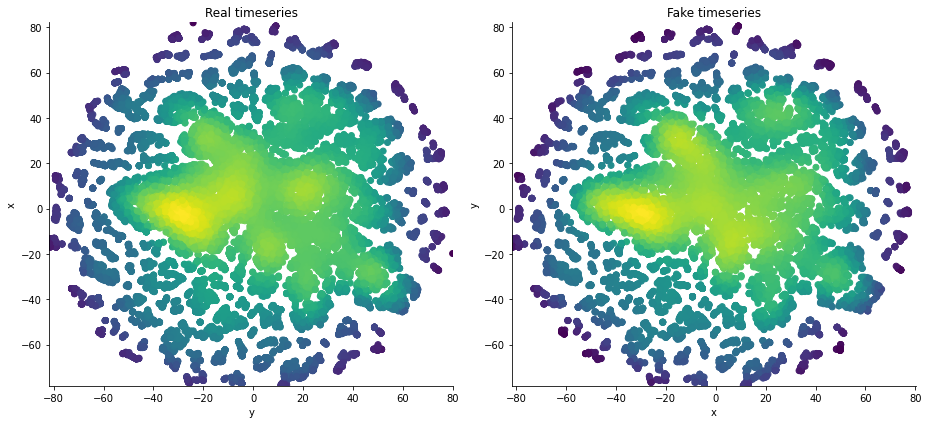

In [47]:
density(projections['tsne_feats'], proj_type='t-SNE_feats')

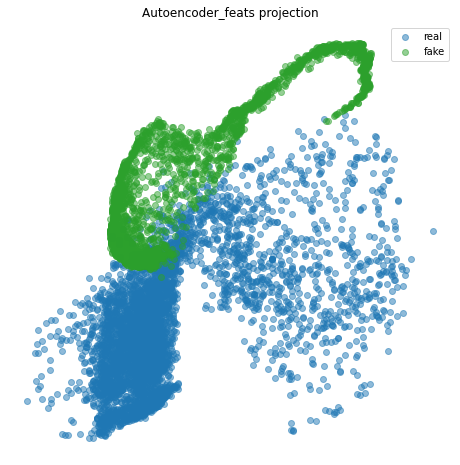

In [48]:
simple_scatter(projections['ae_feats'], proj_type='Autoencoder_feats')

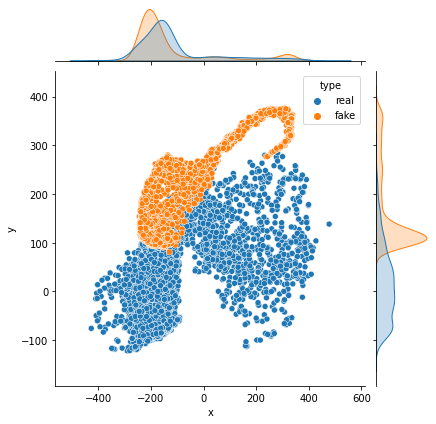

In [49]:
jointplot(projections['ae_feats'], proj_type='Autoencoder_feats')

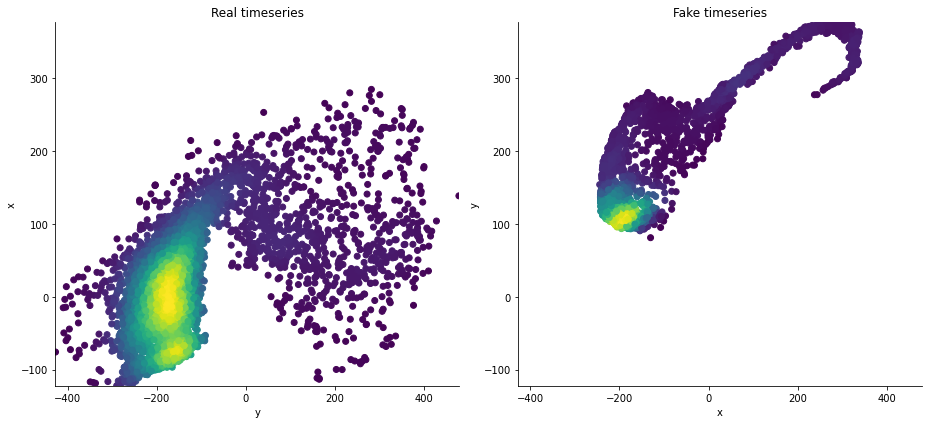

In [50]:
density(projections['ae_feats'], proj_type='Autoencoder_feats')